In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import config
config.update("jax_enable_x64", True)
from jax import grad, jit, vmap
import jax.numpy as jnp
from gwb.omega_gw_jax import OmegaGWjax
# Set matplotlib parameters
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm, colors
font = {'size': 16, 'family': 'serif'}
axislabelfontsize = 'large'
matplotlib.rc('font', **font)
# matplotlib.rc('text', usetex=True)
matplotlib.rc('legend', fontsize=16)


In [2]:
k_max = 6e-3 # <= kmax, #8e-3
eta_R = 20/k_max # k_max*eta_R = 20 well within LISA
params_eMD_RD = [k_max, eta_R]

kmin, kmax = 5e-5, 10**(-2)
k_arr = jnp.logspace(np.log10(kmin), np.log10(kmax), 50) # for Omega, Hz

fac = 10
p_arr = jnp.geomspace(kmin/fac,kmax*fac,200) # for Pzeta, Hz

f = k_arr # jnp.geomspace(1e-3 , 1e-1, 50), Hz

# Needs more accuracy in s
s = jnp.linspace(0., 1., 20)

t = jnp.logspace(-5,5, 1000) 
## Expand t to add a new axis
t_expanded = jnp.expand_dims(t, axis=-1)
## Repeat t along the new axis to match the shape (100, 1000)
t = jnp.repeat(t_expanded, len(f), axis=-1)


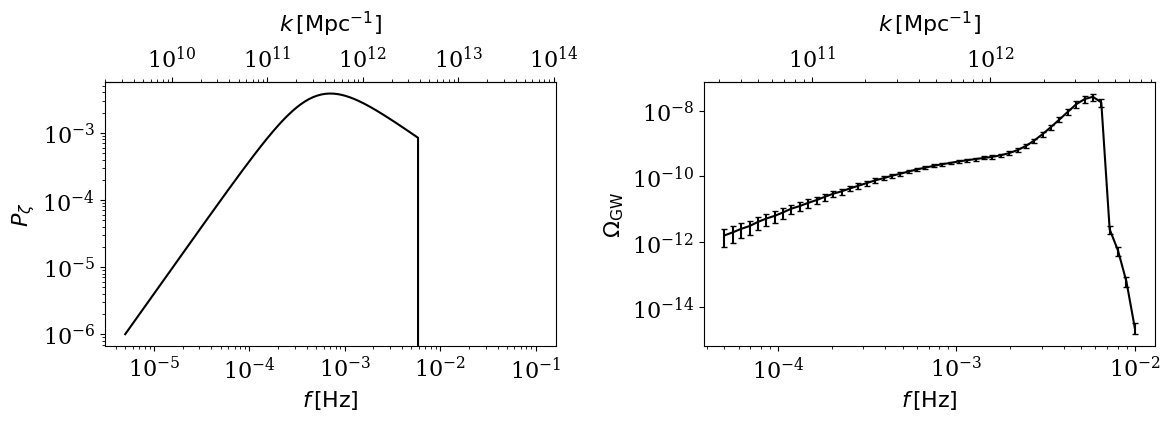

In [3]:
# bpl

@jit
def pzeta_bpl(p, k_max, eta_R, pstar=5e-4, n1=2, n2=-1, sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    result =  1e-2 * pl1 * pl2
    cutoff = jnp.where(p <= k_max, 1.0, 0.0)
    return result *cutoff
    
gwb_calculator =  OmegaGWjax(s, t, f=f, norm="RD", kernel="I_MD_to_RD", upsample=False)

pz_amp = pzeta_bpl(p_arr, *params_eMD_RD)
gwb_amp = gwb_calculator(pzeta_bpl, f, *params_eMD_RD)

kstar = 1e-3
omks_sigma = gwb_amp*( 0.05*(np.log(k_arr/kstar))**2 + 0.1) # 2% error at kstar + more towards edges
gwb_cov = jnp.diag(omks_sigma**2)

np.savez("results/bpl_MDRD_data.npz", k=k_arr, gw=gwb_amp, cov=gwb_cov, p_arr=p_arr, pz_amp=pz_amp)

# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))
ax1.loglog(p_arr, pz_amp, color='k', lw=1.5)
ax1.set_ylabel(r'$P_{\zeta}$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
# ax2.set_ylim(1e-12,1e-7)
ax2.loglog(f, gwb_amp, color='k', lw=1.5)
# ax2.set_ylim(1e-15,1e-5)
ax2.errorbar(f, gwb_amp, yerr=omks_sigma, fmt='none', ecolor='k', capsize=2)
# ax2.fill_between(f, gwb_amp + 1.96 * omks_sigma, gwb_amp - 1.96 * omks_sigma, alpha=0.2, color='k')

# Adjust axes for log scale and add secondary axis for k [Mpc^-1]
for ax in [ax1, ax2]:
    ax.set(yscale='log', xscale='log', xlabel=r'$f\,{\rm [Hz]}$')
# Conversion factor from f (Hz) to k (Mpc^-1)
k_mpc_f_hz = 2 * np.pi * 1.03 * 10 ** 14
for x in [ax1, ax2]:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$", labelpad=10)

# Tight layout for the plot
fig.tight_layout()

# Save the plot
plt.savefig("results/bpl_MDRD_input.pdf")

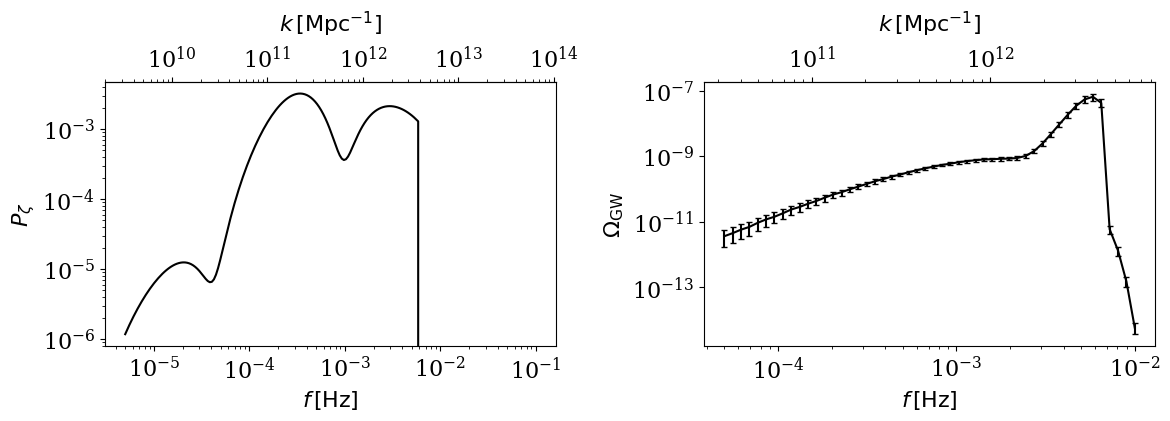

In [4]:
# osc

@jit
def pz_osc(p, k_max, eta_R, pstar=5e-4, n1=2, n2=-1, sigma=2):
    nir = n1
    pl1 = (p/pstar)**nir
    nuv = (n2 - n1)/sigma
    pl2 = (1+(p/pstar)**sigma)**nuv
    osc = (1 + 15*jnp.cos(1*jnp.log(p/2.5))**2)
    result =  1e-3 * pl1 * pl2 *osc
    return result * jnp.heaviside(k_max - p, 1.)
    
gwb_calculator =  OmegaGWjax(s, t, f=f, norm="RD", kernel="I_MD_to_RD", upsample=False)

pz_amp = pz_osc(p_arr, *params_eMD_RD)
gwb_amp = gwb_calculator(pz_osc, f, *params_eMD_RD)

kstar = 1e-3
omks_sigma = gwb_amp*( 0.05*(np.log(k_arr/kstar))**2 + 0.1) # 2% error at kstar + more towards edges
gwb_cov = jnp.diag(omks_sigma**2)

np.savez("results/osc_MDRD_data.npz", k=k_arr, gw=gwb_amp, cov=gwb_cov, p_arr=p_arr, pz_amp=pz_amp)

# Plot the results
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4.5))
ax1.plot(p_arr,pz_amp,color='k',lw=1.5)
ax1.set_ylabel(r'$P_{\zeta}$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax2.plot(f,gwb_amp,color='k',lw=1.5)
ax2.errorbar(f,gwb_amp,yerr=omks_sigma,fmt='none',ecolor='k',capsize=2)
# ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='k')

# Adjust axes for log scale and add secondary axis for k [Mpc^-1]
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$f\,{\rm [Hz]}$')
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in [ax1,ax2]:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
fig.tight_layout()
plt.savefig("results/osc_MDRD_input.pdf")

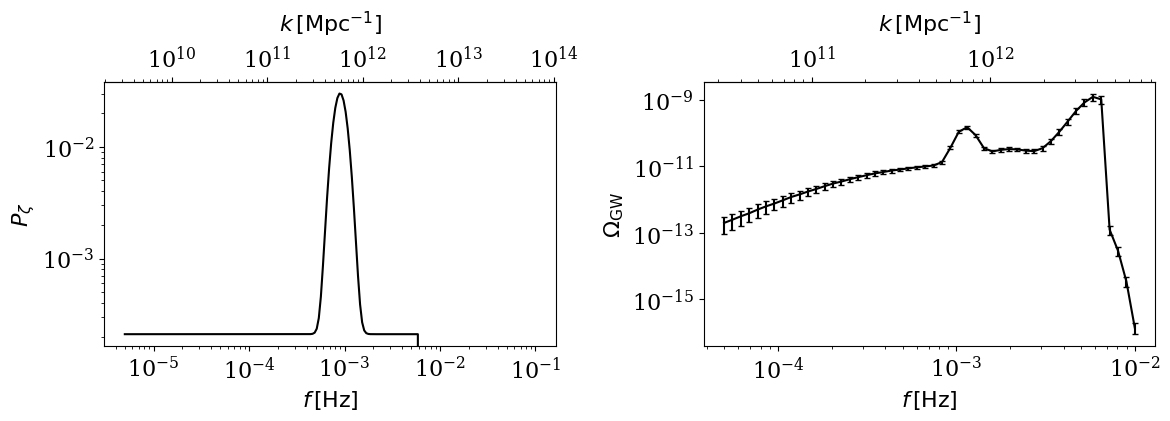

In [5]:
# peaked

# f = k_arr #jnp.geomspace(5e-5, 1e-2, ksize)  # The frequencies to calculate Omega_GW
# s = jnp.linspace(0, 1,50)  # First rescaled internal momentum
# t = jnp.logspace(-6,6, 1000)  # Second rescaled internal momentum


@jit
def pz_peaked(p, k_max, eta_R, pstar=9e-4, sigma=0.15, amp=1e-1, floor=7e-3):
    result = 3e-1 * amp *(floor+ jnp.exp(-0.5*((jnp.log(p/pstar)/sigma)**2)))
    cutoff = jnp.where(p <= k_max, 1.0, 0.0)
    return result * cutoff

pz_amp = pz_peaked(p_arr, *params_eMD_RD)
gwb_amp = gwb_calculator(pz_peaked, f, *params_eMD_RD)

kstar = 1e-3
omks_sigma = gwb_amp*( 0.05*(np.log(k_arr/kstar))**2 + 0.1) # 2% error at kstar + more towards edges
gwb_cov = jnp.diag(omks_sigma**2)

np.savez("results/peaked_MDRD_data.npz", k=k_arr, gw=gwb_amp, cov=gwb_cov, p_arr=p_arr, pz_amp=pz_amp)

# Plot the results
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4.5))
ax1.plot(p_arr,pz_amp,color='k',lw=1.5)
ax1.set_ylabel(r'$P_{\zeta}$')
ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
ax2.plot(f,gwb_amp,color='k',lw=1.5)
ax2.errorbar(f,gwb_amp,yerr=omks_sigma,fmt='none',ecolor='k',capsize=2)
# ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='k')

# Adjust axes for log scale and add secondary axis for k [Mpc^-1]
for ax in [ax1,ax2]:
    ax.set(yscale='log',xscale='log',xlabel=r'$f\,{\rm [Hz]}$')
k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in [ax1,ax2]:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
fig.tight_layout()
plt.savefig("results/peaked_MDRD_input.pdf")

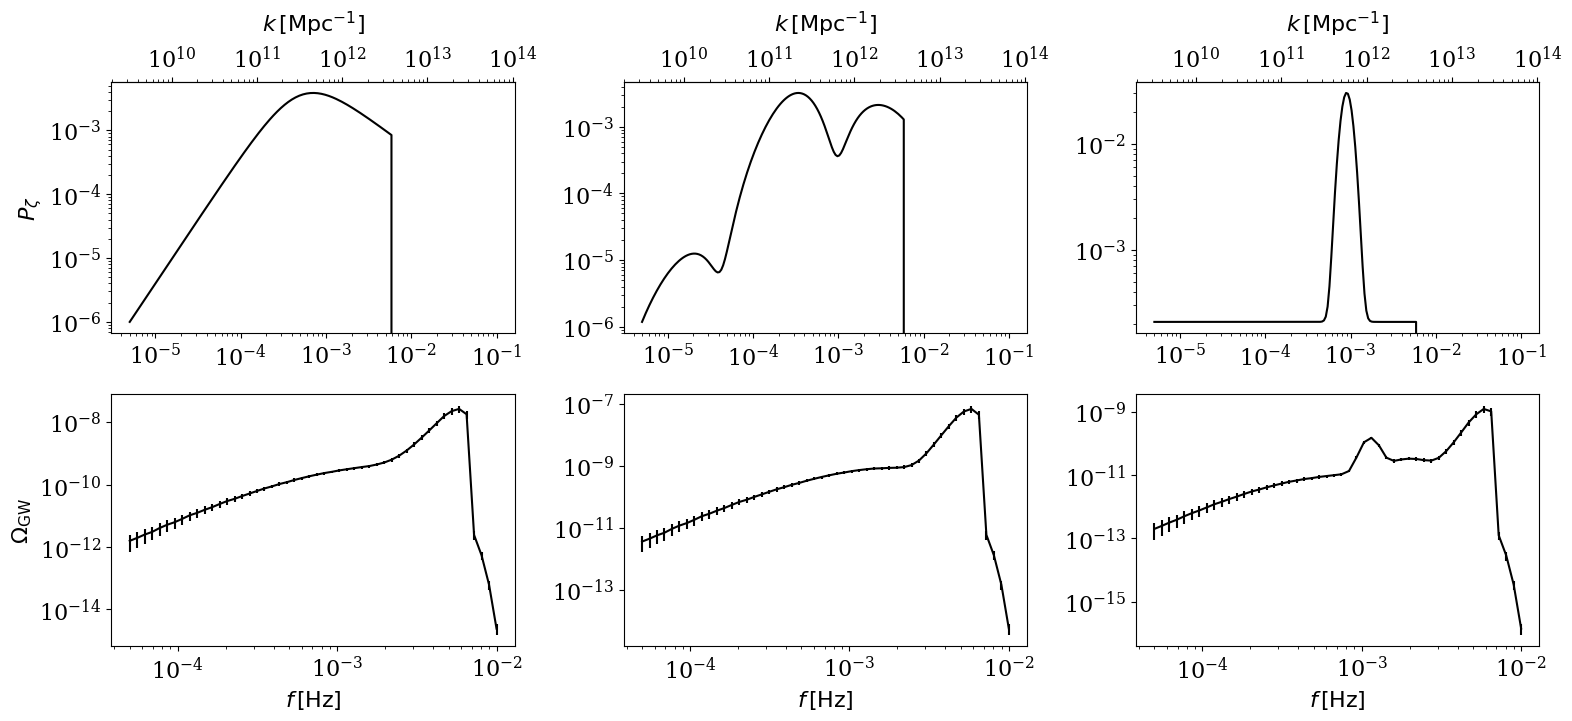

In [6]:
fig,ax = plt.subplots(2,3,figsize=(16,7.5),layout='tight',sharex='row')  
datadir = ['results/bpl_MDRD_data.npz','results/osc_MDRD_data.npz','results/peaked_MDRD_data.npz']


for i in range(3):
    data = np.load(datadir[i])
    k = data['k']
    gw = data['gw']
    cov = data['cov']
    omks_sigma = np.sqrt(np.diag(cov))
    p_arr = data['p_arr']
    pz_amp = data['pz_amp']
    ax[1,i].errorbar(k,gw,yerr=omks_sigma,color='k')
    ax[0,i].loglog(p_arr,pz_amp,color='k')
    # ax[0,i].set_title(['BPL','OSC','PEAKED'][i])
    ax[1,i].set_xscale('log')
    ax[1,i].set_yscale('log')
    ax[1,i].set_xlabel(r'$f\,{\rm [Hz]}$')
ax[0,0].set_ylabel(r'$P_{\zeta}$')
ax[1,0].set_ylabel(r'$\Omega_{\mathrm{GW}}$')

# ax1.plot(p_arr,pz_amp,color='k',lw=1.5)
# ax1.set_ylabel(r'$P_{\zeta}$')
# ax2.set_ylabel(r'$\Omega_{\mathrm{GW}}$')
# ax2.plot(f,gwb_amp,color='k',lw=1.5)
# ax2.errorbar(f,gwb_amp,yerr=omks_sigma,fmt='none',ecolor='k',capsize=2)
# # ax2.fill_between(k_arr,gwb_amp+1.96*omks_sigma,gwb_amp-1.96*omks_sigma,alpha=0.2,color='k')
# for ax in [ax1,ax2]:
#     ax.set(yscale='log',xscale='log',xlabel=r'$f\,{\rm [Hz]}$')
# k_mpc_f_hz = 2*np.pi * 1.03 * 10**14
for x in ax[0,:]:
    secax = x.secondary_xaxis('top', functions=(lambda x: x * k_mpc_f_hz, lambda x: x / k_mpc_f_hz))
    secax.set_xlabel(r"$k\,{\rm [Mpc^{-1}]}$",labelpad=10) 
# fig.tight_layout()
plt.savefig("results/spectra_input.pdf")